# <center> Challenges of motherhood - Young MUM’s urgent questions - Part 2: Topic Modelling - LDA and BERTopic

In [1]:
# importing needed packages
import pandas as pd
from collections import Counter
import re
import numpy as np
from operator import itemgetter
from random import sample
from functools import reduce
import operator
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
import os
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from bertopic import BERTopic
from umap import UMAP
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

## Importing already preprocessed Data

In [2]:
df_message = pd.read_csv('preprocessed_data_final.csv',low_memory=False)
df_message_new = pd.DataFrame({'Page Name':df_message['Page Name'],'Message': df_message['Message'],'preprocessed_as_string': df_message['preprocessed_as_string']})
df_message_new['preprocessed'] = df_message_new['preprocessed_as_string'].str.split("\\s")

In [3]:
df_message_new.head()

,Page Name,Message,preprocessed_as_string,preprocessed
0,Serdar Somuncu,Baby wo?,babi,[babi]
1,KNITZ,Nachwehen?,nachwehen,[nachwehen]
2,Schlager.de - Klatsch,Baby Nr. 4?,babi nr,"[babi, nr]"
3,iKON (with iKONIC) International Fans,Baby hanbin?,babi hanbin,"[babi, hanbin]"
4,Stillen & Chillen,Abstillen?! 😉,abstillen,[abstillen]


In [4]:
df_message_new.shape

(115434, 4)

## Topic Modelling

After simply counting the frequency of the words, the following two topic modeling techniques are used:

* Latent Dirichlet Allocation (LDA)
* BERTopic

### Simply counting words

In [12]:
# select 1000 random posts and count word frequency
random_sample_of_indices = sample(range(len(df_message_new['preprocessed'])),1000)
l1 = reduce(operator.concat, df_message_new['preprocessed'][random_sample_of_indices])

In [13]:
c = Counter(l1)
c.most_common(10)

[('babi', 703),
 ('mehr', 318),
 ('schon', 298),
 ('geburt', 290),
 ('immer', 290),
 ('kind', 282),
 ('gibt', 243),
 ('mal', 241),
 ('ganz', 238),
 ('kinder', 223)]

#### Wordcloud

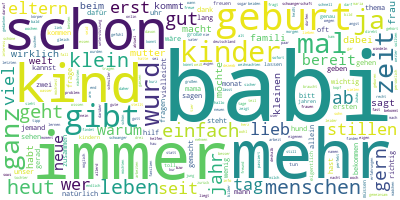

In [14]:
# join the different words of the first n posts together
long_string = sum(df_message_new['preprocessed'][random_sample_of_indices], [])
long_string = ','.join(long_string)

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

In [15]:
wordcloud.to_file('Wordcloud.png')

### Latent Dirichlet Allocation (LDA)

#### Converting text to bag of words

The preprocessed text is converted to a bag of words, which is a kind of dictionary where the key is the word and value is the number of times that word occurs in the entire corpus.

For each pre-processed post the dictionary object just created is used to convert that post into a bag of words. i.e for each post we create a dictionary reporting how many words and how many times those words appear.

In [9]:
# creating dictionary
id2word = corpora.Dictionary(df_message_new['preprocessed'])
# creating corpus
texts = df_message_new['preprocessed']
# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]
# view
print(corpus[:1][0][:30])

[(0, 1)]


#### Running LDA

For running LDA the gensim LDA model can be used. How many topics are there in the data set has to be specified.

In [10]:
# number of topics
num_topics = 23

In [11]:
# building LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state=1234)
# printing the keywords in the topics of 5 topics to give an impression
pprint(lda_model.print_topics()[:5])
doc_lda = lda_model[corpus]

[(4,
  '0.014*"babi" + 0.010*"schon" + 0.007*"mal" + 0.007*"lieb" + 0.006*"stillen" '
  '+ 0.006*"zeit" + 0.005*"wurd" + 0.005*"seit" + 0.005*"menschen" + '
  '0.004*"mehr"'),
 (10,
  '0.016*"babi" + 0.006*"ganz" + 0.005*"geburt" + 0.004*"heut" + '
  '0.004*"fragen" + 0.004*"schon" + 0.004*"stillen" + 0.004*"mal" + '
  '0.004*"hallo" + 0.003*"immer"'),
 (5,
  '0.018*"babi" + 0.014*"user" + 0.007*"mehr" + 0.006*"ganz" + 0.005*"mal" + '
  '0.005*"leben" + 0.005*"gibt" + 0.005*"schon" + 0.005*"mama" + 0.005*"viel"'),
 (12,
  '0.019*"babi" + 0.004*"jemand" + 0.004*"beim" + 0.004*"ab" + 0.003*"gibt" + '
  '0.003*"geburt" + 0.003*"heut" + 0.003*"geht" + 0.003*"welt" + '
  '0.003*"hallo"'),
 (15,
  '0.027*"babi" + 0.006*"immer" + 0.004*"mal" + 0.004*"schon" + 0.004*"jemand" '
  '+ 0.004*"ersten" + 0.004*"erst" + 0.004*"gibt" + 0.004*"ja" + '
  '0.003*"mutter"')]


In [ ]:
# visualizing the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared'+'.html')
LDAvis_prepared

**Extracting the topics:**

In [15]:
# extracting the probabilities for the individual posts belonging to the different topics
topics = [lda_model[corpus[i]] for i in range(len(df_message_new['preprocessed']))]

In [16]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [17]:
# like TF-IDF, creating a matrix of topic weighting, with posts as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [18]:
# example: with a probability of 0.68 post 50 belongs to topic 19
document_topic.iloc[50]

0     0.014493
1     0.014493
2     0.014493
3     0.014493
4     0.014493
5     0.014493
6     0.014493
7     0.014493
8     0.014493
9     0.014493
10    0.014493
11    0.014493
12    0.014493
13    0.014493
14    0.014493
15    0.014493
16    0.014493
17    0.014493
18    0.014493
19    0.681145
20    0.014493
21    0.014493
22    0.014493
Name: 50, dtype: float64

In [21]:
# Which posts are about topic 4
document_topic.sort_values(4, ascending=False)[4].head(20)

35272    0.978695
21894    0.974840
26220    0.971483
32996    0.969998
24123    0.968183
33469    0.965684
30770    0.965675
29523    0.964478
35743    0.964455
38982    0.964353
35049    0.964169
13811    0.963081
33760    0.962763
33513    0.961699
31688    0.961651
27906    0.961567
34493    0.961445
32781    0.961430
31967    0.960100
26181    0.959943
Name: 4, dtype: float64

In [22]:
# assigning to each post the topic with the highest probability
topic_assignment = []
for i in lda_model[corpus]:
    #print(i)
    test_list = []
    for l in i:
        test_list.append(l)
    topic_assignment.append((max(test_list,key=itemgetter(1))[0]))

In [23]:
# example: topic 19 has been assigned to post 50
topic_assignment[50]

19

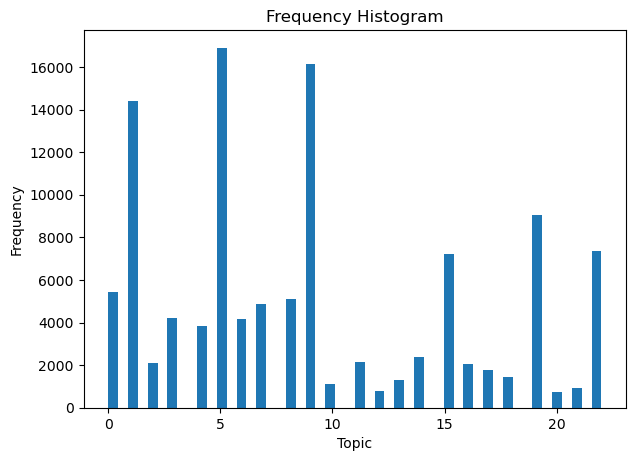

In [25]:
# number of posts per topic 
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# plotting histogram on topic_assignment
plt.hist(topic_assignment,bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency',xlabel='Topic');

In [26]:
# creating subset of original dataset
sentence_topic = pd.concat([pd.DataFrame(df_message_new['Message']),pd.DataFrame(df_message_new['preprocessed']), pd.DataFrame(topic_assignment,columns=['topic'])], axis=1)
sentence_topic.head()

,Message,preprocessed,topic
0,Baby wo?,[babi],15
1,Nachwehen?,[nachwehen],1
2,Baby Nr. 4?,"[babi, nr]",9
3,Baby hanbin?,"[babi, hanbin]",8
4,Abstillen?! 😉,[abstillen],6


In [27]:
# adding 1 to topic column to avoid that there is a topic "0"
sentence_topic['topic']=sentence_topic['topic']+1

**Interpretation of possible topics:**

Analysis of 100 random selected posts from each topic helps to interpret the topic and to tell what the topic is about. 

In [28]:
# Interpretation of a specific topic (selected_topic)
selected_topic = 1
selected_topic_data = sentence_topic[sentence_topic['topic']==selected_topic]
selected_topic_data.shape

(5413, 3)

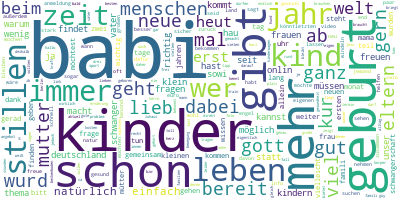

In [29]:
# creating wordcloud to get a first impression of the content of the selected topic
random_sample_of_indices2 = sample(list(sentence_topic[sentence_topic['topic']==selected_topic]['preprocessed'].index),min(selected_topic_data.shape[0],2000))

long_string = sum(sentence_topic[sentence_topic['topic']==selected_topic]['preprocessed'][random_sample_of_indices2], [])
long_string = ','.join(long_string)

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [30]:
pd.set_option('max_colwidth', None)
pd.set_option('min_rows', None)

In [ ]:
selected_topic_data.sample(100)

**Inference:** Despite varying the two hyperparameters, number of topics and random state, the topics could not be interpreted. No matter how the number of topics has been chosen, multiple subjects are summarized in one topic while one subject is split in multiple topics at the same time. So, there is no clear assignment of one subject, like illness or breast feeding, to one topic.

Therefore, another topic modelling technique is used. -> BERTopic

### Topic Modeling with BERTopic

BERTopic is a Python module developed by Maarten Grootendorst that is specialized on the extraction of topics from text. It uses a method based on BERT and a modified TF-IDF analysis.

In [14]:
# define the umap_model in advance with the default parameters to define random_state to make the model reproducible
umap_model = UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.0, n_components=5,random_state=123)
model = BERTopic(language="german", nr_topics="auto",umap_model=umap_model)

From model.fit_transform two lists are returned:
* topics - contains a one-to-one mapping of inputs to their modeled topic (or cluster)
* probs - contains a list of probabilities that an input belongs to their assigned topic

In [ ]:
topics, probs = model.fit_transform(df_message_new['preprocessed_as_string'])

In [17]:
# looking at model parameters
model.get_params()

{'calculate_probabilities': False,
 'diversity': None,
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x7f82efc1aeb0>,
 'hdbscan_model': HDBSCAN(min_cluster_size=10, prediction_data=True),
 'language': 'german',
 'low_memory': False,
 'min_topic_size': 10,
 'n_gram_range': (1, 1),
 'nr_topics': 'auto',
 'seed_topic_list': None,
 'top_n_words': 10,
 'umap_model': UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.0, n_components=5, random_state=123, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 'vectorizer_model': CountVectorizer(),
 'verbose': False}

In [18]:
# number of topics that could be found
model.get_topic_freq().shape

(568, 2)

In [19]:
# accessing the topics (and number of posts in them) that were generated by their relative frequency
model.get_topic_freq().head(10)

,Topic,Count
0,-1,67564
1,0,7856
2,1,2896
3,2,1796
4,3,1488
5,4,1257
6,5,1187
7,6,1121
8,7,1021
9,8,809


In [ ]:
# saving the model
model.save("my_bertopic_model_default")

Topic -1 refers to all outliers which do not have a topic assigned. Forcing posts in a topic could lead to poor performance. Thus, topic -1 could be ignored.

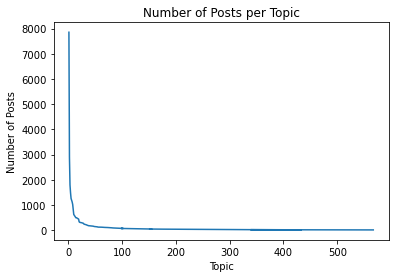

In [16]:
# plotting number of posts per topic
plt.plot(model.get_topic_freq()['Count'].drop([0]))
plt.title("Number of Posts per Topic")
plt.xlabel('Topic') 
plt.ylabel('Number of Posts') 
plt.savefig('TopicsFrequency_selPages.png')
plt.show()

In [17]:
# viewing the topics using get_topic_info
model.get_topic_info().head(10)

,Topic,Count,Name
0,-1,67564,-1_babi_schon_kind_mehr
1,0,7856,0_famili_hund_wurd_jahr
2,1,2896,1_schwangerschaft_schwanger_abtreibung_geburt
3,2,1796,2_schlafen_schlaf_schläft_einschlafen
4,3,1488,3_jesu_gott_christu_heiligen
5,4,1257,4_katzen_katz_kitten_kater
6,5,1187,5_fit_sport_train_beckenboden
7,6,1121,6_album_song_the_dj
8,7,1021,7_politik_afd_demokrati_politisch
9,8,809,8_windeln_windel_windelfrei_größe


In [20]:
# looking into one topic could be done with get_topic
model.get_topic(2)

[('schlafen', 0.023447727991723975),
 ('schlaf', 0.021036894879730317),
 ('schläft', 0.019308644113374164),
 ('einschlafen', 0.012419220763119992),
 ('nacht', 0.010747241146168691),
 ('babyschlaf', 0.010691051719831793),
 ('durchschlafen', 0.008245378012742036),
 ('bett', 0.007268028798732244),
 ('schlafsack', 0.00629795846769646),
 ('babi', 0.00517536717903676)]

In [ ]:
# visualizing all the topics
model.visualize_barchart(top_n_topics=38,n_words=10)

In [ ]:
# visualizing the topics in a distance map where similar topics are close to each other
model.visualize_topics()

In [5]:
# getting representative posts per topic
model.get_representative_docs(2)

['schläft babi kühlen nächten gut kleidung richtig hebamm steffi tipp babyschlaf herbstzeit',
 'babysprechstund novemb mütze roth fragen ernährung gesunden schlaf entwicklung kind kommen einfach mal vorbei kinderkrankenschwest steht fragen rund babi rede antwort',
 'unser schlafsprechstund beantwortet expertin fragen thema babyschlaf mal ab wann babi elternschlafzimm ausquartieren']

In [ ]:
# visualizing the correlation/similarity score between the topics
model.visualize_heatmap()

**Conclusion:** 

The runtime to fit the model was much higher than for the reduced dataset.
Analyzation of the topics has shown that the topics that have been found for the restricted dataset were also found in the whole dataset. A lot of topics have been found that do not fit and are not appropriate for our use case. These topics have to be excluded. Appearance of these not suitable topics happened since the dataset is not as clear as the reduced dataset. Even though a lot of data cleaning and data preparation has been done, there are a lot of posts included that do not directly relate to the subject.